# The `ecco_access` modules: a starting point for accessing ECCO output on PO.DAAC

Andrew Delman, updated 2025-04-30

[Introduction](#introduction)\
[Importing `ecco_access` to your workspace](#add-ecco-access)\
[Using the `ecco_podaac_to_xrdataset` function](#using-ecco-podaac-to-xrdataset)\
[Using the `ecco_podaac_access` function](#using-ecco-podaac-access)\
[Accessing ECCOv4 release 5 output](#accessing-eccov4r5)

## Introduction

In the past several years since ECCOv4 release 4 output was made available on the Physical Oceanography Distributed Active Archive Center or [PO.DAAC](https://podaac.jpl.nasa.gov), a number of Python scripts/functions have been written to facilitate requests of this output, authored by Jack McNelis, Ian Fenty, and Andrew Delman. These codes have been consolidated into the **ecco_access** modules, in order to standardize the format of the requests.

```{note}
As of April 2025, the **ecco_access** modules are included in the `ecco_v4_py` Python package. There should no longer be a need to clone the *ECCO-v4-Python-Tutorial* repo to use these tools. Instead, you should clone the *ECCOv4-py* repo that contains `ecco_v4_py`, as described [below](https://ecco-summer-school.github.io/ecco-2025/tutorials/ECCO_data_access/ECCO_access_intro.html#add-ecco-access).
```

This tutorial will help you to start using the **ecco_access** library, which is comprised of a set of Python modules. Here we introduce the two top-level functions in **ecco_access**:

- `ecco_podaac_to_xrdataset`: takes as input a text query or ECCO dataset identifier, and returns an *xarray* Dataset

- `ecco_podaac_access`: takes the same input, but returns the URLs/paths or local files where the data is located


(add-ecco-access)=
## Importing `ecco_access` to your workspace

As of the latest update (April 2025), `ecco_access` modules are included in `ecco_v4_py`. To use them, you will need the latest version of `ecco_v4_py` (1.7.4.1 or later) which is not yet available through `conda-forge` or `Anaconda` channels. It **is** available through `pypi`, which means that on your local machine or anywhere else you can just run `python -m pip install -U ecco_v4_py` in your conda environment to install the latest version.

However...the Docker image that is used when launching our OSS servers has an older version of `ecco_v4_py` (1.6.0) which does not have `ecco_access`. If you run the `pip install` command above, it will install the newer version, but then the next time you start an OSS server (which you will probably do at least once daily during the summer school) it will revert to the older version in the Docker image.

On OSS, one way around this is to clone the repository containing `ecco_v4_py` into your home directory filesystem (which is preserved when you start a new server). And then tell your Python notebooks and code to use the version in the cloned repository, rather than the version in the default path for packages.

To do this, [open up a terminal window](https://ecco-summer-school.github.io/ecco-2025/preliminary/git_access.html#open-a-terminal) in OSS. Then navigate to your home directory and `git clone` the `ECCOv4-py` repository that contains `ecco_v4_py`:

```shell
cd ~
git clone https://github.com/ECCO-GROUP/ECCOv4-py.git
```

Or if you have a Github [SSH key](https://ecco-summer-school.github.io/ecco-2025/preliminary/git_access.html#option-2-set-up-ssh-key-ssh-access), instead of the 2nd line above you could use `git clone git@github.com:ECCO-GROUP/ECCOv4-py.git`.

Now that you have the repository with the newer `ecco_v4_py`, you should have these lines of Python code near the beginning of each notebook when using the *ecco_access* utilities:

```python
from os.path import join,expanduser
import sys
sys.path.insert(0,join(expanduser('~'),'ECCOv4-py'))
import ecco_v4_py.ecco_access as ea
```

```{note}
You can also import *ecco_access* into your workspace just by importing `ecco_v4_py` rather than `ecco_v4_py.ecco_access`. The high-level functions discussed below should work either way. Importing `ecco_v4_py.ecco_access` is just a little more direct, especially if you are only using the access-related functions of `ecco_v4_py`.
```


(using-ecco-podaac-to-xrdataset)=
## Using the `ecco_podaac_to_xrdataset` function

Perhaps the most convenient way to use *ecco_access* is the `ecco_podaac_to_xrdataset`; it takes as input a *query* consisting of NASA Earthdata dataset ShortName(s), ECCO variables, or text strings in the variable descriptions, and outputs an *xarray* Dataset. Let's look at the syntax:

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository, rather than the pre-installed older version
from os.path import join,expanduser
import sys
sys.path.insert(0,join(expanduser('~'),'ECCOv4-py'))

import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea

# identify user's home directory
user_home_dir = expanduser('~')

In [2]:
help(ea.ecco_podaac_to_xrdataset)

Help on function ecco_podaac_to_xrdataset in module ecco_v4_py.ecco_access:

ecco_podaac_to_xrdataset(query, version='v4r4', grid=None, time_res='all', StartDate=None, EndDate=None, snapshot_interval=None, mode='download_ifspace', download_root_dir=None, **kwargs)
    This function queries and accesses ECCO datasets from PO.DAAC. The core query and download functions 
    are adapted from Jupyter notebooks created by Jack McNelis and Ian Fenty 
    (https://github.com/ECCO-GROUP/ECCO-ACCESS/blob/master/PODAAC/Downloading_ECCO_datasets_from_PODAAC/README.md)
    and modified by Andrew Delman (https://ecco-v4-python-tutorial.readthedocs.io).
    It is similar to ecco_podaac_access, except instead of a list of URLs or files, 
    an xarray Dataset with all of the queried ECCO datasets is returned.
    
    Parameters
    ----------    
    query: str, list, or dict, defines datasets or variables to access.
           If query is str, it specifies either a dataset ShortName (if query 
    

There are a lot of options that you *can* use to "submit" a query with this function. Let's consider a simple case, where we already have the ShortName for the [monthly native grid SSH](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_monthly_varlist.txt) from ECCOv4r4 (**ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4**), and we want to access output from the year 2017. The ShortName goes in the query field, and we can specify start and end dates (in *YYYY-MM* or *YYYY-MM-DD* format). The other options that matter most for this request are the *mode*, and depending on the mode, the *download_root_dir* or the *jsons_root_dir*.

### Direct download over the internet (mode = 'download')

Let's try the **download** mode, which retrieves the data over the Internet using NASA Earthdata URLs (this should work on any machine with Internet access, including cloud environments):

In [3]:
# download data and open xarray dataset
curr_shortname = 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4'
ds_SSH = ea.ecco_podaac_to_xrdataset(curr_shortname,\
                                        StartDate='2017-01',EndDate='2017-12',\
                                        mode='download',\
                                        download_root_dir=join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC'))

created download directory /home/jovyan/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4
DL Progress: 100%|#########################| 12/12 [00:05<00:00,  2.16it/s]

total downloaded: 71.02 Mb
avg download speed: 12.76 Mb/s
Time spent = 5.56673002243042 seconds




We specified a *root* directory for the download (which also happens to be the default setting), and the data files are then placed under *download_root_dir* / ShortName. We can verify that the contents of the file are what we queried:

In [4]:
ds_SSH

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 12, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2017-01-16T12:00:00 ... 2017-12-16T0...
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2017-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2017-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a21a5c30-400c-11eb-a9e0-0cc47a3f49c3

### In-cloud direct access with pre-generated json files (mode = 's3_open_fsspec')

Now, if you are part of the ECCO Hackweek you are also working in a cloud environment which means that you have many more access modes open to you. Let's try **s3_open_fsspec**, which opens the files from S3 (no download necessary), and uses json files with the data chunking information to open the files exceptionally fast. This means you need to provide the directory where the jsons are located, on the `efs_ecco` drive: `/efs_ecco/mzz-jsons`.

In [5]:
curr_shortname = 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4'
ds_SSH_s3 = ea.ecco_podaac_to_xrdataset(curr_shortname,\
                                        StartDate='2017-01',EndDate='2017-12',\
                                        mode='s3_open_fsspec',\
                                        jsons_root_dir=join('/efs_ecco','mzz-jsons'))

In [6]:
ds_SSH_s3

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 12, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90, nv: 2)
Coordinates: (12/13)
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    ...         ...
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2017-01-16T12:00:00 ... 2017-12-16T0...
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    ETAN       (time, tile, j, i) float32 5MB dask.array<chunksize=(12, 13, 90, 90), meta=np.ndarray>
    SSH        (time, tile, j, i) float32 5MB dask.array<chunksize=(12, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 5MB dask.array<chunksize=(12, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 5MB dask.array<chunksize=(12, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9302811e-400c-11eb-b69e-0cc47a3f49c3

Now plot the SSH for Jan 2017 in tile 10 (Python numbering convention; 11 in Fortran/MATLAB numbering convention). Here we use the "RdYlBu" colormap, one of [many built-in colormaps](https://matplotlib.org/stable/gallery/color/colormap_reference.html) that the `matplotlib` package provides, or you can [create your own](https://matplotlib.org/stable/users/explain/colors/colormap-manipulation.html#colormap-manipulation). The "_r" at the end reverses the direction of the colormap, so red corresponds to the maximum values.

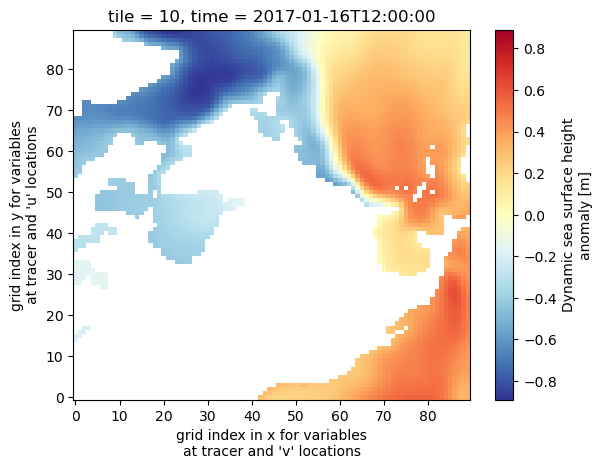

In [7]:
ds_SSH_s3.SSH.isel(time=0,tile=10).plot(cmap='RdYlBu_r')

We can also use the `ecco_v4_py` package to plot a global map of Jan 2017 SSH, using the `plot_proj_to_latlon_grid` function which regrids from the native LLC grid to a lat/lon grid.

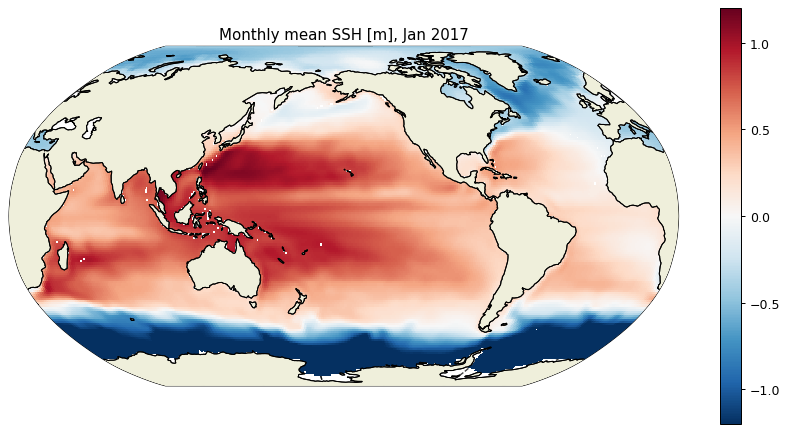

In [8]:
plt.figure(figsize=(12,6), dpi= 90)
ecco.plot_proj_to_latlon_grid(ds_SSH_s3.XC, ds_SSH_s3.YC, \
                              ds_SSH_s3.SSH.isel(time=0), \
                              user_lon_0=-160,\
                              projection_type='robin',\
                              plot_type='pcolormesh', \
                              cmap='RdBu_r',\
                              dx=1,dy=1,cmin=-1.2, cmax=1.2,show_colorbar=True)
plt.title('Monthly mean SSH [m], Jan 2017')
plt.show()

### What if you don't know the ShortName already?

[NASA Earthdata](https://search.earthdata.nasa.gov/search) datasets are identified by ShortNames, but you might not know the ShortName of the variable or category of variables that you are seeking. One way to find the ShortName is to consult these [ECCOv4r4 variable lists](https://ecco-hackweek.github.io/ecco-2024/tutorials/ECCO_data_access/ECCO_data_structure.html#dataset-shortnames-and-variables-associated-with-them). But the "query" in `ecco_access` functions does not have to be a ShortName; it can also be a text string representing a variable name, or a word or phrase in the variable description.

For example, perhaps you are looking to open the dataset that has native grid monthly sea ice concentration in 2007. If the query is not identified as a ShortName, then a text search of the [variable lists](https://ecco-hackweek.github.io/ecco-2024/tutorials/ECCO_data_access/ECCO_data_structure.html#dataset-shortnames-and-variables-associated-with-them) is conducted using *query*, *grid*, and *time_res*. Then of the identified matches, the user is asked to select one.

In [9]:
ds_seaice_conc = ea.ecco_podaac_to_xrdataset('ice',grid='native',time_res='monthly',\
                                               StartDate='2007-01',EndDate='2007-12',\
                                               mode='s3_open_fsspec',\
                                               jsons_root_dir=join('/efs_ecco','mzz-jsons'))

ShortName Options for query "ice":
                  Variable Name     Description (units)

Option 1: ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4    *native grid,monthly means*
                  SSH               Dynamic sea surface height anomaly. Suitable for
                                    comparisons with altimetry sea surface height data
                                    products that apply the inverse barometer
                                    correction. (m)
                  SSHIBC            The inverted barometer correction to sea surface
                                    height due to atmospheric pressure loading. (m)
                  SSHNOIBC          Sea surface height anomaly without the inverted
                                    barometer correction. Suitable for comparisons
                                    with altimetry sea surface height data products
                                    that do NOT apply the inverse barometer
                                

Please select option [1-8]:  5


Using dataset with ShortName: ECCO_L4_SEA_ICE_CONC_THICKNESS_LLC0090GRID_MONTHLY_V4R4


We selected option 5, corresponding to ShortName ECCO_L4_SEA_ICE_CONC_THICKNESS_LLC0090GRID_MONTHLY_V4R4. Let's look at the dataset contents.

In [10]:
ds_seaice_conc

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 12, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90, nv: 2)
Coordinates: (12/13)
    XC         (tile, j, i) float32 421kB ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    XG         (tile, j_g, i_g) float32 421kB ...
    YC         (tile, j, i) float32 421kB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
    YG         (tile, j_g, i_g) float32 421kB ...
    ...         ...
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2007-01-16T12:00:00 ... 2007-12-16T1...
    time_bnds  (time, nv) datetime64[ns] 192B ...
Dimensions without coordinates: nb, nv
Data variables:
    SIarea     (time, tile, j, i) float32 5MB ...
    SIheff     (time, tile, j, i) float32 5MB ...
    SIhsnow    (time, tile, j, i) float32 5MB ...
    sIceLoad   (time, tile, j, i) float32 5MB ...
Attributes: (12/57)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea-Ice and Snow Concentration and Thi...
    uuid:                         cc62f1c2-400d-11eb-9f11-0cc47a3f49c3

Now plot the sea ice concentration/fraction in tile 6 (which approximately covers the Arctic Ocean), during Sep 2007 which at the time was a record minimum for Arctic sea ice.

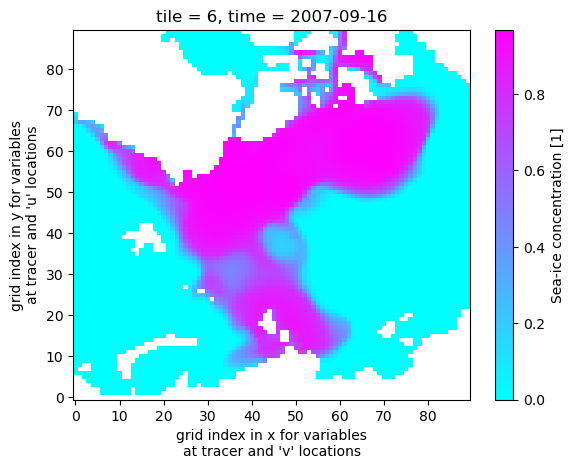

In [11]:
ds_seaice_conc.SIarea.isel(time=8,tile=6).plot(cmap='cool')

(using-ecco-podaac-access)=
## Using the `ecco_podaac_access` function

### In-cloud direct access (mode = 's3_open')

The `ecco_podaac_to_xrdataset` function that was previously used invokes `ecco_podaac_access` under the hood, and `ecco_podaac_access` can also be called directly. This can be useful if you want to obtain a list of file objects/paths or URLs that you can then process with your own code. Let's use this function with mode = `s3_open` (all `s3` modes only work from an AWS cloud environment in region `us-west-2`).

In [12]:
files_dict = ea.ecco_podaac_access(curr_shortname,\
                                    StartDate='2015-01',EndDate='2015-12',\
                                    mode='s3_open')

{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2015-01-02,2015-12-31'}

Total number of matching granules: 12


In [13]:
files_dict[curr_shortname]

[<File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-01_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-02_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-03_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-04_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-05_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-06_ECCO_V4r4_native_llc0090.nc>,
 <File-lik

The output of `ecco_podaac_access` is in the form of a dictionary with ShortNames as keys. In this case, the value associated with this ShortName is a list of 12 file objects. These are files on `S3` (AWS's cloud storage system) that have been opened, which is a necessary step for the files' data to be accessed. The list of open files can be passed directly to `xarray.open_mfdataset`.

In [14]:
ds_SSH_fromlist = xr.open_mfdataset(files_dict[curr_shortname],\
                                    compat='override',data_vars='minimal',coords='minimal',\
                                    parallel=True)

In [15]:
ds_SSH_fromlist

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 12, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T1...
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2015-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2015-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a4955186-400c-11eb-8c14-0cc47a3f49c3

(accessing-eccov4r5)=
## Accessing ECCOv4 release 5 output

In addition to accessing the ECCOv4r4 Central Estimate output released on PO.DAAC, *ecco_access* functions can also retrieve output from the newer release 5 (ECCOv4r5). Unlike v4r4, for which many fields can be accessed at monthly/daily/snapshot time resolutions and native/latlon grid configurations, only the v4r5 monthly mean native grid outputs are currently accessible, and only working within the AWS Cloud. However, a number of fields were archived in v4r5 that were not archived in v4r4, including the terms of momentum and sea-ice budgets.

### SST comparison: v4r4 vs. v4r5

First let's consider a field that is archived in both releases: potential temperature in the top layer, or SST. Accessing the monthly mean potential temperature for 1998 from v4r4 (and assuming we don't know the ShortName already):

In [16]:
ds_T_v4r4 = ea.ecco_podaac_to_xrdataset('temperature',\
                                            version='v4r4',grid='native',time_res='monthly',\
                                            StartDate='1998-01',EndDate='1998-12',\
                                            mode='s3_open_fsspec',\
                                            jsons_root_dir=join('/efs_ecco','mzz-jsons'))

ShortName Options for query "temperature":
                  Variable Name     Description (units)

Option 1: ECCO_L4_ATM_STATE_LLC0090GRID_MONTHLY_V4R4    *native grid,monthly means*
                  EXFatemp          Atmosphere surface (2 m) air temperature (degK)
                  EXFaqh            Atmosphere surface (2 m) specific humidity (kg/kg)
                  EXFuwind          Wind speed at 10m in the model +x direction (m/s)
                  EXFvwind          Wind speed at 10m in the model +y direction (m/s)
                  EXFwspee          Wind speed (m/s)
                  EXFpress          Atmosphere surface pressure (N/m^2)

Option 2: ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4    *native grid,monthly means*
                  EXFhl             Open ocean air-sea latent heat flux (W/m^2)
                  EXFhs             Open ocean air-sea sensible heat flux (W/m^2)
                  EXFlwdn           Downward longwave radiative flux (W/m^2)
                  EXFswd

Please select option [1-5]:  4


Using dataset with ShortName: ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4


In [17]:
ds_T_v4r4

<xarray.Dataset> Size: 510MB
Dimensions:    (time: 12, k: 50, tile: 13, j: 90, i: 90, nb: 4, j_g: 90,
                i_g: 90, nv: 2, k_l: 50, k_p1: 51, k_u: 50)
Coordinates: (12/22)
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    ...         ...
  * k_l        (k_l) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 1998-01-16T12:00:00 ... 1998-12-16T1...
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    SALT       (time, k, tile, j, i) float32 253MB dask.array<chunksize=(6, 50, 13, 90, 90), meta=np.ndarray>
    THETA      (time, k, tile, j, i) float32 253MB dask.array<chunksize=(6, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f07693e6-4181-11eb-beb3-0cc47a3f44ff

Now try the same thing, but with v4r5:

```{attention}
The v4r5 outputs are currently accessed not through PO.DAAC's S3 bucket, but on the `s3://ecco-model-granules/` bucket. This bucket is a ["requester pays"](https://docs.aws.amazon.com/AmazonS3/latest/userguide/RequesterPaysBuckets.html) bucket, which means that the entity requesting the data (i.e., you) would pay the data transfer fees. However, no need to get alarmed! When transferring data within the same AWS region as the bucket, the requester does not have to pay any data transfer fees. OSS and the p-cluster are set up in the same region *us-west-2 (Oregon)* as the `ecco-model-granules` bucket, so there should be no cost to the data transfer.

When accessing data from the `ecco-model-granules` bucket, a prompt appears by default to remind the user that the data access is "requester pays". This prompt can be suppressed by setting `prompt_request_payer=False`.
```

In [18]:
ds_T_v4r5 = ea.ecco_podaac_to_xrdataset('temperature',\
                                            version='v4r5',grid='native',time_res='monthly',\
                                            StartDate='1998-01',EndDate='1998-12',\
                                            mode='s3_open',\
                                            prompt_request_payer=False)

ShortName Options for query "temperature":
                  Variable Name     Description (units)

Option 1: ECCO_L4_ATM_SURFACE_TEMP_HUM_WIND_PRES_LLC0090GRID_MONTHLY_V4R5    *native grid,monthly means*
                  EXFatemp          Surface (2 m) air temperature over open water.
                                    (degK)
                  EXFaqh            Surface (2 m) specific humidity over open water.
                                    (kg/kg)
                  EXFpress          Atmospheric pressure field at sea level. (N/m^2)
                  EXFuwind          Wind speed at 10m in the +x direction at the
                                    tracer cell on the native model grid. (m/s)
                  EXFvwind          Wind speed at 10m in the +y direction at the
                                    tracer cell on the native model grid. (m/s)
                  EXFwspee          10-m wind speed magnitude (>= 0 ) over open water.
                                    (m/s)

Opt

Please select option [1-4]:  4


Using dataset with ShortName: ECCO_L4_OCEAN_TEMPERATURE_SALINITY_LLC0090GRID_MONTHLY_V4R5

Total number of matching granules: 12


In [19]:
ds_T_v4r5

<xarray.Dataset> Size: 510MB
Dimensions:    (time: 12, k: 50, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90,
                k_u: 50, k_l: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 253MB dask.array<chunksize=(1, 25, 7, 45, 45), meta=np.ndarray>
    SALT       (time, k, tile, j, i) float32 253MB dask.array<chunksize=(1, 25, 7, 45, 45), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1998-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1998-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            4e98cffa-89b5-11ef-b1f2-062b596a220b

Now plot a map of the difference in surface potential temperature (i.e., SST) between the two releases, on tile 10 in May 1998.

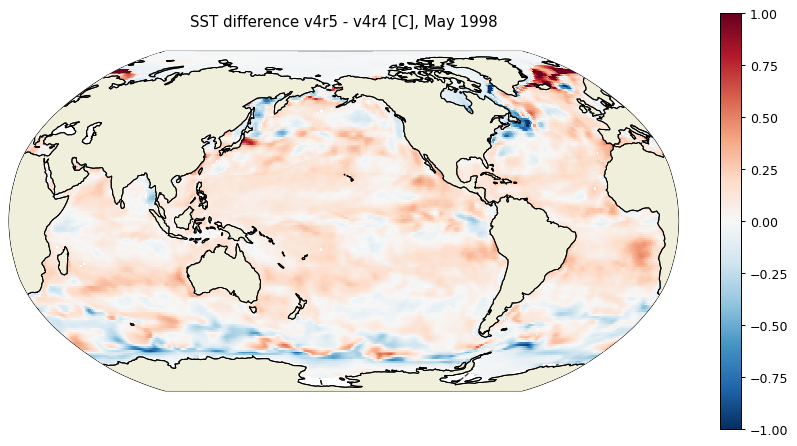

In [20]:
T_diff = ds_T_v4r5.THETA - ds_T_v4r4.THETA
plt.figure(figsize=(12,6), dpi= 90)
ecco.plot_proj_to_latlon_grid(ds_T_v4r4.XC, ds_T_v4r4.YC, \
                              T_diff.isel(time=4,k=0), \
                              user_lon_0=-160,\
                              projection_type='robin',\
                              plot_type='pcolormesh', \
                              cmap='RdBu_r',\
                              dx=1,dy=1,cmin=-1, cmax=1,show_colorbar=True)
plt.title('SST difference v4r5 - v4r4 [C], May 1998\n')
plt.show()

### Momentum budget terms in v4r5

Now, let's consider a dataset that was *only* archived in v4r5, not v4r4: the terms of the momentum budget. We will access and view the terms of the $u$-momentum budget, i.e., the momentum along the $x$-axis of the llc90 native grid.

```{note}
ECCOv4r5 has two different sets of momentum budget terms archived. The first set (options 1 and 2) below quantifies the effect of (lateral) vorticity advection vs. other advection terms that contribute to the momentum budget (vertical and kinetic energy gradient). The second set (options 5 and 6) consists of the primitive equations that describe $u$- and $v$-momentum tendency, which you probably learned in introductory fluid dynamics classes. We consider the second set below.
```

In [21]:
# u-momentum budget terms
ds_u_mom = ea.ecco_podaac_to_xrdataset('momentum',\
                                            version='v4r5',grid='native',time_res='monthly',\
                                            StartDate='1998-01',EndDate='1998-12',\
                                            mode='s3_open',\
                                            prompt_request_payer=False)

ShortName Options for query "momentum":
                  Variable Name     Description (units)

Option 1: ECCO_L4_OCEAN_3D_MOMENTUM_ADV_TEND_X_LLC0090GRID_MONTHLY_V4R5    *native grid,monthly means*
                  Um_AdvZ3          U momentum tendency from vorticity advection.
                                    (m/s^2)
                  Um_AdvRe          U momentum tendency from vertical advection,
                                    explicit part. (m/s^2)
                  Um_dKEdx          U momentum tendency from grad KE. (m/s^2)

Option 2: ECCO_L4_OCEAN_3D_MOMENTUM_ADV_TEND_Y_LLC0090GRID_MONTHLY_V4R5    *native grid,monthly means*
                  Vm_AdvZ3          V momentum tendency from vorticity advection.
                                    (m/s^2)
                  Vm_AdvRe          V momentum tendency from vertical advection,
                                    explicit part. (m/s^2)
                  Vm_dKEdy          V momentum tendency from grad KE. (m/s^2)

Option 

Please select option [1-6]:  5


Using dataset with ShortName: ECCO_L4_OCEAN_3D_MOMENTUM_TEND_X_LLC0090GRID_MONTHLY_V4R5

Total number of matching granules: 12


Let's plot the Coriolis and pressure gradient contributions to the model $u$-momentum budget on tile 7 (North Pacific). This is a rotated tile, which means the positive $x$ direction is *southward*. Hence the $u$-momentum budget corresponds to approximately the meridional momentum budget, with the sign reversed.

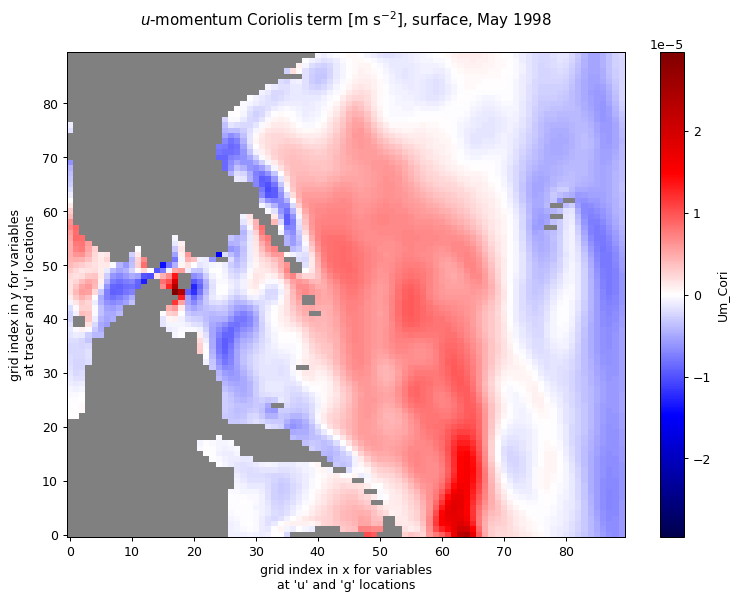

In [22]:
import matplotlib as mpl
seismic_nanmasked = mpl.colormaps['seismic'].copy()
seismic_nanmasked.set_bad('gray')

plt.figure(figsize=(10,7), dpi= 90)
ds_u_mom.Um_Cori.isel(time=4,k=0,tile=7).plot(cmap=seismic_nanmasked)
plt.title('$u$-momentum Coriolis term [m s$^{-2}$], surface, May 1998\n')
plt.show()

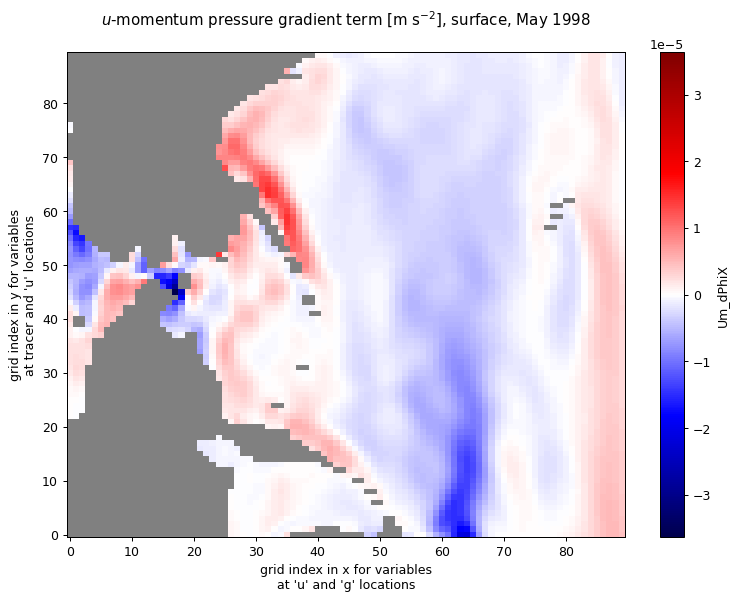

In [23]:
plt.figure(figsize=(10,7),dpi=90)
ds_u_mom.Um_dPhiX.isel(time=4,k=0,tile=7).plot(cmap=seismic_nanmasked)
plt.title('$u$-momentum pressure gradient term [m s$^{-2}$], surface, May 1998\n')
plt.show()

The fact that these two terms are nearly equal and opposite reflects the dominance of geostrophic balance. The sum of these terms (below) mostly is balanced by meridional Ekman transport.

In [24]:
Cori_plus_pgrad = ds_u_mom.Um_Cori + ds_u_mom.Um_dPhiX

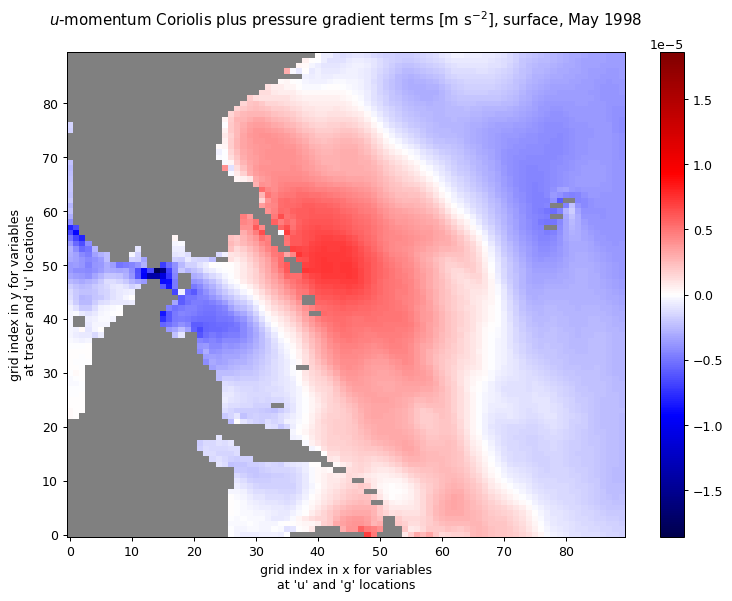

In [25]:
plt.figure(figsize=(10,7),dpi=90)
Cori_plus_pgrad.isel(time=4,k=0,tile=7).plot(cmap=seismic_nanmasked)
plt.title('$u$-momentum Coriolis plus pressure gradient terms [m s$^{-2}$], surface, May 1998\n')
plt.show()

If we look at a level well below the surface (~200 m), the sum of the two terms is even smaller.

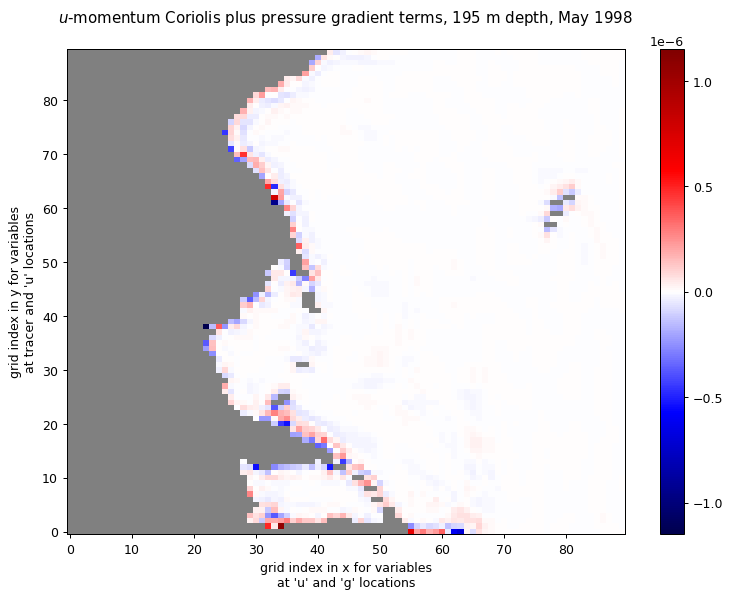

In [26]:
plt.figure(figsize=(10,7),dpi=90)
Cori_plus_pgrad.isel(time=4,k=16,tile=7).plot(cmap=seismic_nanmasked)
plt.title('$u$-momentum Coriolis plus pressure gradient terms [m s$^{-2}$], 195 m depth, May 1998\n')
plt.show()

```{exercise}
Try plotting the terms of the meridional momentum budget globally. To do this successfully you will need both the $u$- and $v$-momentum terms, and to regrid and rotate them with the $CS$ and $SN$ parameters in the grid file (you can use the v4r4 grid file for this). [This tutorial](https://ecco-summer-school.github.io/ecco-2025/tutorials/ECCO_v4_computations/ECCO_v4_Gradient_calc_on_native_grid.html) is a good resource for how to do this on the llc90 grid.
```